<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training the Conditional Auto-Encoder with the settings obtained from Optimization


In [5]:
import tensorflow as tf
tf.__version__
tf.config.list_physical_devices('GPU')


import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
import logging
import sys
from sklearn import preprocessing
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Reshape, LeakyReLU, BatchNormalization, Dense, Flatten, Input,Dropout
import random
import numpy as np
import pickle

In [6]:
SMALL_SIZE =  14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [7]:
RUN             = '1'

seeds           = {'1':5123, '2':879, '3':9981, '4': 20075, '5': 66, '6': 276, '7': 936664}

conditional     = False
cond_on         = 'type'

root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'
root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.1
max_z           = 0.36
label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)
label_          = label+'_minz%s_maxz%s_minSN%d'%(str(int(min_z*100)).zfill(3),str(int(max_z*100)).zfill(3),min_SN)
label_2         = label_+'_10_fully_connected_mean_div'

plotpath        = '/global/homes/v/vboehm/codes/SDSS_PAE/figures'


if conditional:
    label_2='conditional_%s'%cond_on+label_2

In [8]:
train_,valid_,test_,le = pickle.load(open(os.path.join(root_model_data,'combined_%s.pkl'%label_),'rb'))

In [9]:
train, valid, test, mean, std = np.load(os.path.join(root_decoded,'decoded_%s_RUN%s.npy'%(label_2,RUN)), allow_pickle=True)

In [10]:
path = os.path.join(root_models,'encoder_%s_run%s'%(label_2, RUN))
encoder = tf.keras.models.load_model(path)
path = os.path.join(root_models,'decoder_%s_run%s'%(label_2, RUN))
decoder = tf.keras.models.load_model(path)

In [11]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 1000)              1001000   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1000)              0         
_________________________________________________________________
reshape (Reshape)            (None, 1000, 1)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1000, 1)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 590)               5

In [12]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          multiple                  0         
_________________________________________________________________
flatten_3 (Flatten)          multiple                  0         
_________________________________________________________________
dense_3 (Dense)              multiple                  6490      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    multiple                  0         
_________________________________________________________________
reshape_4 (Reshape)          multiple                  0         
_________________________________________________________________
flatten_4 (Flatten)          multiple                  0         
_________________________________________________________________
dense_4 (Dense)              multiple                 

In [13]:
input = Input((1000,1))

x = encoder(input)
x = decoder(x)

AE_2 = Model(input,x)

In [14]:
AE_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1000, 1)]         0         
_________________________________________________________________
sequential (Sequential)      (None, 10, 1)             1597500   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1000)              1598490   
Total params: 3,195,990
Trainable params: 3,195,990
Non-trainable params: 0
_________________________________________________________________


In [15]:
random.seed(seeds[RUN])
np.random.seed(seeds[RUN])
tf.random.set_seed(seeds[RUN])

In [16]:
opt = tf.keras.optimizers.Adam
lr  = learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(1e-3,20000,5e-5,power=0.5, cycle=False) 
AE_2.compile(loss='mean_squared_error', metrics='mean_squared_error', optimizer=opt(lr))

In [17]:
AE_2.fit(x=np.expand_dims(train,-1), y=np.expand_dims(train,-1),validation_data=(np.expand_dims(valid,-1),np.expand_dims(valid,-1)), epochs=55, batch_size=25)

Epoch 1/55
2154/2154 [==============================] - 5s 2ms/step - loss: 0.5644 - mean_squared_error: 0.5644 - val_loss: 0.0197 - val_mean_squared_error: 0.0197
Epoch 2/55
2154/2154 [==============================] - 4s 2ms/step - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0212 - val_mean_squared_error: 0.0212
Epoch 3/55
2154/2154 [==============================] - 4s 2ms/step - loss: 0.4406 - mean_squared_error: 0.4406 - val_loss: 0.0149 - val_mean_squared_error: 0.0149
Epoch 4/55
2154/2154 [==============================] - 4s 2ms/step - loss: 1.2357 - mean_squared_error: 1.2357 - val_loss: 0.0919 - val_mean_squared_error: 0.0919
Epoch 5/55
2154/2154 [==============================] - 4s 2ms/step - loss: 0.5833 - mean_squared_error: 0.5833 - val_loss: 0.0530 - val_mean_squared_error: 0.0530
Epoch 6/55
2154/2154 [==============================] - 4s 2ms/step - loss: 0.0370 - mean_squared_error: 0.0370 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
Epoch 7/55
2154/

In [18]:
predict = AE_2.predict(valid)

In [19]:
latent_dim=10

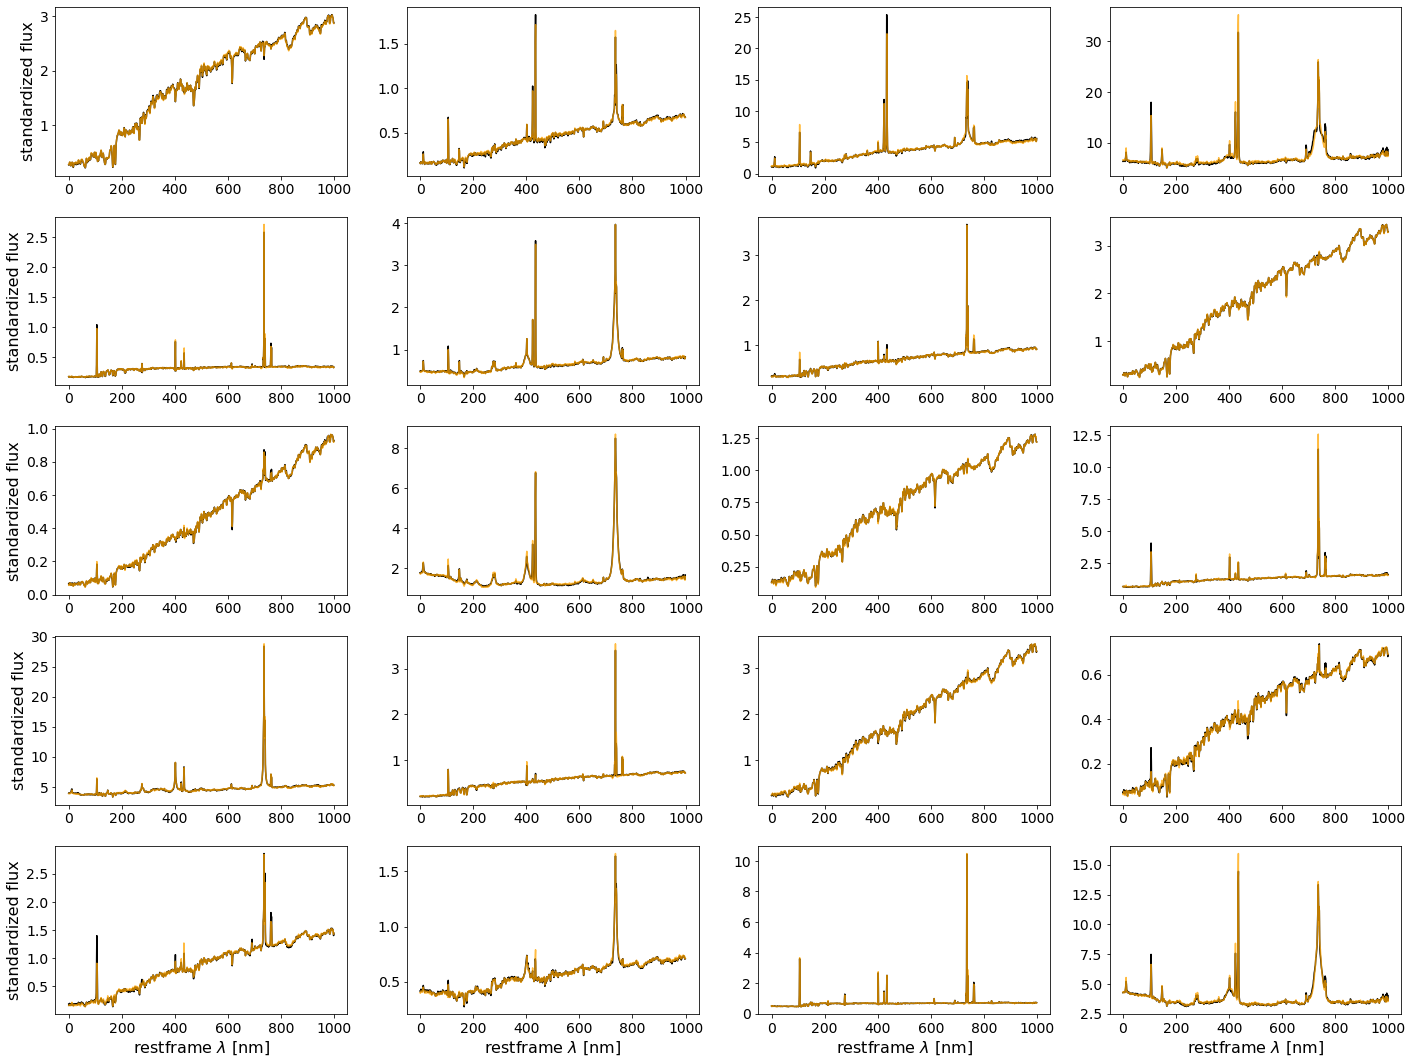

In [34]:
style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.

fig, ax = plt.subplots(5,4, figsize=(20,15))
ax = ax.flatten()
for nn, ii in enumerate(np.arange(20)):
    ind = (valid_['subclass']==(nn%7))
    ax[nn].plot(valid[ind][ii], color='k')
    ax[nn].plot(predict[ind][ii], color='orange', ls='-',alpha=0.75)
    if nn in [16,17,18,19]:
        ax[ii].set_xlabel(r'restframe $\lambda$ [nm]')
    if ii%4==0:
        ax[ii].set_ylabel(r'standardized flux')    
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'reconstructions_test_AE2.pdf'), bbox_inches='tight')
plt.show()

In [24]:
wlmin, wlmax    = (3388,8318)
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

In [25]:
loss = np.mean((valid-predict)**2,axis=0)

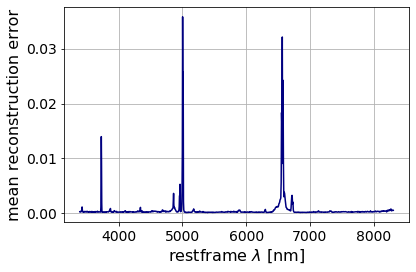

In [26]:
plt.plot(new_wl[:-1],loss,color='navy')
plt.xlabel(r'restframe $\lambda$ [nm]')
plt.ylabel('mean reconstruction error')
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'mean_reconstruction_error_AE2.pdf'), bbox_inches='tight')

In [27]:
path = os.path.join(root_models,'full_ae_model_%s_run%s_denoised_inpainted'%(label_2,RUN))
AE_2.save(path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/full_ae_model_galaxies_quasars_bins1000_wl3388-8318_minz010_maxz036_minSN50_10_fully_connected_mean_div_run1_denoised_inpainted/assets


In [28]:
def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
    new_model = Sequential()
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(ix, curr_layer)
        new_model.add(curr_layer)
    return new_model

In [29]:
encoder = extract_layers(AE_2,0,2)
encoder.build((None,fixed_num_bins,1))
encoder.summary()

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x2aaaaede3610>
1 <tensorflow.python.keras.engine.sequential.Sequential object at 0x2aab97067910>
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 10, 1)             1597500   
Total params: 1,597,500
Trainable params: 1,597,500
Non-trainable params: 0
_________________________________________________________________


In [30]:
encoded_valid = encoder.predict(valid)
encoded_train = encoder.predict(train)
encoded_test  = encoder.predict(test)

In [31]:
path = os.path.join(root_encoded,'encoder_AE2_%s_run%s_inpainted_denoised'%(label_2, RUN))
encoder.save(path)

INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Datasets/encoded/sdss/encoder_AE2_galaxies_quasars_bins1000_wl3388-8318_minz010_maxz036_minSN50_10_fully_connected_mean_div_run1_inpainted_denoised/assets


In [32]:
encoded_valid = np.squeeze(encoded_valid)
encoded_train = np.squeeze(encoded_train)
encoded_test  = np.squeeze(encoded_test)
np.save(os.path.join(root_encoded,'encoded_AE2_%s_RUN%s.npy'%(label_2,RUN)),[encoded_train, encoded_valid, encoded_test])


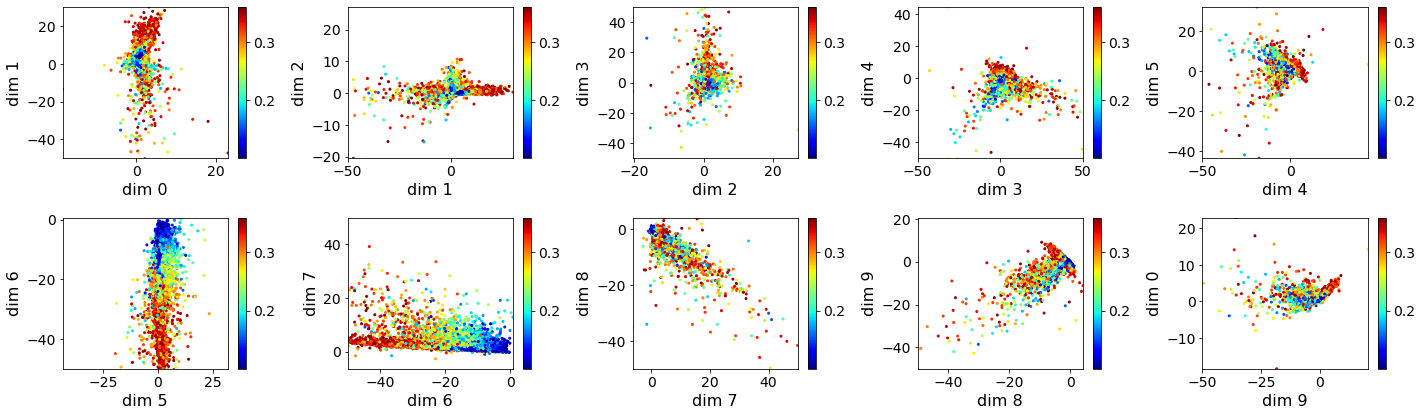

In [35]:
lims = 50

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,6))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid_['z'], cmap='jet',s=4)
    ax[ii].set_xlim(max(min(encoded_valid[:,ii]),-lims),min(max(encoded_valid[:,ii]),lims))
    ax[ii].set_ylim(max(min(encoded_valid[:,jj]),-lims),min(max(encoded_valid[:,jj]),lims))
    ax[ii].set_xlabel('dim %d'%ii)
    ax[ii].set_ylabel('dim %d'%jj)
    plt.colorbar(im, ax=ax[ii])
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'encoded_redshift_AE2.pdf'), bbox_inches='tight')
plt.show()


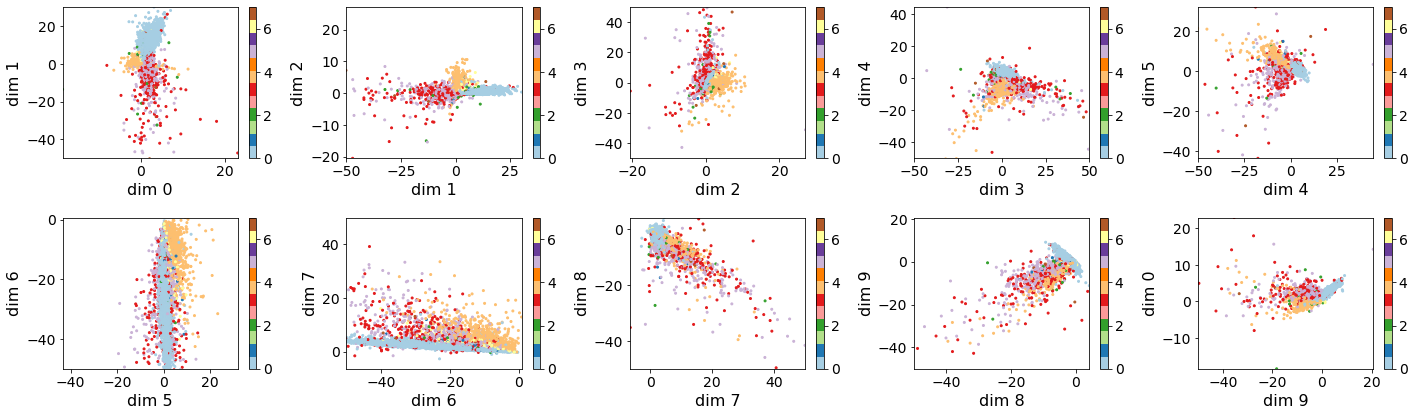

In [36]:
lims = 50

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,6))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid_['subclass'], cmap='Paired', s=4)
    ax[ii].set_xlim(max(min(encoded_valid[:,ii]),-lims),min(max(encoded_valid[:,ii]),lims))
    ax[ii].set_ylim(max(min(encoded_valid[:,jj]),-lims),min(max(encoded_valid[:,jj]),lims))
    ax[ii].set_xlabel('dim %d'%ii)
    ax[ii].set_ylabel('dim %d'%jj)
    plt.colorbar(im, ax=ax[ii])
plt.tight_layout()
plt.savefig(os.path.join(plotpath,'encoded_subclass_AE2.pdf'), bbox_inches='tight')
plt.show()
